In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE

%matplotlib inline
pd.set_option('display.max_columns', 100)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in ve

## 1. Import and Cleaning Data

In [2]:
bc = pd.read_csv("breast-cancer.csv")

In [3]:
bc.head(3)

,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class
0,'40-49','premeno','15-19','0-2','yes','3','right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no','1','right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no','2','left','left_low','no','recurrence-events'


In [4]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
age            286 non-null object
menopause      286 non-null object
tumor_size     286 non-null object
inv_nodes      286 non-null object
node_caps      278 non-null object
deg_malig      286 non-null object
breast         286 non-null object
breast_quad    285 non-null object
irradiat       286 non-null object
class          286 non-null object
dtypes: object(10)
memory usage: 22.5+ KB


In [5]:
# check null values
bc.isnull().sum()

age            0
menopause      0
tumor_size     0
inv_nodes      0
node_caps      8
deg_malig      0
breast         0
breast_quad    1
irradiat       0
class          0
dtype: int64

Karena ada null values di datasetnya, saya akan lalukan cleaning data pada ``node_caps`` dan ``breast_quad``.

In [6]:
bc_cl = bc.drop(bc[bc.node_caps.isnull() == True].index, axis=0)
bc_clean = bc_cl.drop(bc_cl[bc_cl.breast_quad.isnull() == True].index, axis=0)
bc_clean.head()

,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class
0,'40-49','premeno','15-19','0-2','yes','3','right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no','1','right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no','2','left','left_low','no','recurrence-events'
3,'40-49','premeno','35-39','0-2','yes','3','right','left_low','yes','no-recurrence-events'
4,'40-49','premeno','30-34','3-5','yes','2','left','right_up','no','recurrence-events'


In [7]:
bc_clean.isnull().sum()

age            0
menopause      0
tumor_size     0
inv_nodes      0
node_caps      0
deg_malig      0
breast         0
breast_quad    0
irradiat       0
class          0
dtype: int64

## 2. Convert Data

In [8]:
# checking str data in deg_malig column
bc_clean.deg_malig.value_counts().head()

'2'    129
'3'     82
'1'     66
Name: deg_malig, dtype: int64

In [9]:
def int_conv(x):
    if x == "'1'":
        return 1
    elif x == "'2'":
        return 2
    else:
        return 3

In [10]:
bc_clean['deg_malig'] = bc_clean['deg_malig'].apply(int_conv)
bc_clean.head(3)

,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class
0,'40-49','premeno','15-19','0-2','yes',3,'right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no',1,'right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no',2,'left','left_low','no','recurrence-events'


In [11]:
bc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 285
Data columns (total 10 columns):
age            277 non-null object
menopause      277 non-null object
tumor_size     277 non-null object
inv_nodes      277 non-null object
node_caps      277 non-null object
deg_malig      277 non-null int64
breast         277 non-null object
breast_quad    277 non-null object
irradiat       277 non-null object
class          277 non-null object
dtypes: int64(1), object(9)
memory usage: 23.8+ KB


Karena saya cek data pada dataset ini berupa ``categorical data`` sehingga masih banyak yang merupakan ``str data`` di beberapa kolom, saya akan coba melakukan convert data ke ``int`` dengan melakukan get_dummies agar bisa melakukan proses analisisnya.

Untuk ``node_caps``, ``breast``, ``irradiat`` dan ``class`` karena binary data, saya akan melakukan convert dengan memakai function saja.

In [12]:
def yesno_conv(x):
    if x == "'yes'":
        return 1
    else:
        return 0

In [13]:
bc_clean['node_caps'] = bc_clean['node_caps'].apply(yesno_conv)
bc_clean.head(3)

,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class
0,'40-49','premeno','15-19','0-2',1,3,'right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2',0,1,'right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2',0,2,'left','left_low','no','recurrence-events'


In [14]:
bc_clean['irradiat'] = bc_clean['irradiat'].apply(yesno_conv)
bc_clean.head(3)

,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class
0,'40-49','premeno','15-19','0-2',1,3,'right','left_up',0,'recurrence-events'
1,'50-59','ge40','15-19','0-2',0,1,'right','central',0,'no-recurrence-events'
2,'50-59','ge40','35-39','0-2',0,2,'left','left_low',0,'recurrence-events'


In [15]:
# checking unique values di class column
bc_clean['class'].unique()

array(["'recurrence-events'", "'no-recurrence-events'"], dtype=object)

In [16]:
def class_conv(x):
    if x == "'no-recurrence-events'":
        return 0
    else:
        return 1

In [17]:
bc_clean['class'] = bc_clean['class'].apply(class_conv)
bc_clean.head(3)

,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class
0,'40-49','premeno','15-19','0-2',1,3,'right','left_up',0,1
1,'50-59','ge40','15-19','0-2',0,1,'right','central',0,0
2,'50-59','ge40','35-39','0-2',0,2,'left','left_low',0,1


In [18]:
bc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 285
Data columns (total 10 columns):
age            277 non-null object
menopause      277 non-null object
tumor_size     277 non-null object
inv_nodes      277 non-null object
node_caps      277 non-null int64
deg_malig      277 non-null int64
breast         277 non-null object
breast_quad    277 non-null object
irradiat       277 non-null int64
class          277 non-null int64
dtypes: int64(4), object(6)
memory usage: 23.8+ KB


In [19]:
bc_dum = pd.get_dummies(data=bc_clean, columns=['age'])
bc_dum

,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79'
0,'premeno','15-19','0-2',1,3,'right','left_up',0,1,0,0,1,0,0,0
1,'ge40','15-19','0-2',0,1,'right','central',0,0,0,0,0,1,0,0
2,'ge40','35-39','0-2',0,2,'left','left_low',0,1,0,0,0,1,0,0
3,'premeno','35-39','0-2',1,3,'right','left_low',1,0,0,0,1,0,0,0
4,'premeno','30-34','3-5',1,2,'left','right_up',0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,'ge40','30-34','6-8',1,2,'left','left_low',0,0,0,0,0,1,0,0
282,'premeno','25-29','3-5',1,2,'left','left_low',1,0,0,0,0,1,0,0
283,'premeno','30-34','6-8',1,2,'right','right_up',0,0,0,1,0,0,0,0
284,'premeno','15-19','0-2',0,2,'right','left_low',0,0,0,0,0,1,0,0


In [20]:
bc_dum = pd.get_dummies(data=bc_dum, columns=['menopause'])
bc_dum

,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno'
0,'15-19','0-2',1,3,'right','left_up',0,1,0,0,1,0,0,0,0,0,1
1,'15-19','0-2',0,1,'right','central',0,0,0,0,0,1,0,0,1,0,0
2,'35-39','0-2',0,2,'left','left_low',0,1,0,0,0,1,0,0,1,0,0
3,'35-39','0-2',1,3,'right','left_low',1,0,0,0,1,0,0,0,0,0,1
4,'30-34','3-5',1,2,'left','right_up',0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,'30-34','6-8',1,2,'left','left_low',0,0,0,0,0,1,0,0,1,0,0
282,'25-29','3-5',1,2,'left','left_low',1,0,0,0,0,1,0,0,0,0,1
283,'30-34','6-8',1,2,'right','right_up',0,0,0,1,0,0,0,0,0,0,1
284,'15-19','0-2',0,2,'right','left_low',0,0,0,0,0,1,0,0,0,0,1


In [21]:
bc_dum = pd.get_dummies(data=bc_dum, columns=['tumor_size'])
bc_dum

,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat,class,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54'
0,'0-2',1,3,'right','left_up',0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,'0-2',0,1,'right','central',0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,'0-2',0,2,'left','left_low',0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,'0-2',1,3,'right','left_low',1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,'3-5',1,2,'left','right_up',0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,'6-8',1,2,'left','left_low',0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
282,'3-5',1,2,'left','left_low',1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
283,'6-8',1,2,'right','right_up',0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
284,'0-2',0,2,'right','left_low',0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [22]:
bc_dum = pd.get_dummies(data=bc_dum, columns=['inv_nodes'])
bc_dum

,node_caps,deg_malig,breast,breast_quad,irradiat,class,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11'
0,1,3,'right','left_up',0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,1,'right','central',0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,2,'left','left_low',0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,1,3,'right','left_low',1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,1,2,'left','right_up',0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,2,'left','left_low',0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
282,1,2,'left','left_low',1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
283,1,2,'right','right_up',0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
284,0,2,'right','left_low',0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [23]:
bc_dum = pd.get_dummies(data=bc_dum, columns=['breast'])
bc_dum

,node_caps,deg_malig,breast_quad,irradiat,class,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',breast_'left',breast_'right'
0,1,3,'left_up',0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,1,'central',0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,2,'left_low',0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,1,3,'left_low',1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1,2,'right_up',0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,2,'left_low',0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
282,1,2,'left_low',1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
283,1,2,'right_up',0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
284,0,2,'left_low',0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [24]:
bc_dum = pd.get_dummies(data=bc_dum, columns=['breast_quad'])
bc_dum

,node_caps,deg_malig,irradiat,class,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',breast_'left',breast_'right',breast_quad_'central',breast_quad_'left_low',breast_quad_'left_up',breast_quad_'right_low',breast_quad_'right_up'
0,1,3,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,3,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
4,1,2,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
282,1,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
283,1,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
284,0,2,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0


In [25]:
bc_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 285
Data columns (total 38 columns):
node_caps                  277 non-null int64
deg_malig                  277 non-null int64
irradiat                   277 non-null int64
class                      277 non-null int64
age_'20-29'                277 non-null uint8
age_'30-39'                277 non-null uint8
age_'40-49'                277 non-null uint8
age_'50-59'                277 non-null uint8
age_'60-69'                277 non-null uint8
age_'70-79'                277 non-null uint8
menopause_'ge40'           277 non-null uint8
menopause_'lt40'           277 non-null uint8
menopause_'premeno'        277 non-null uint8
tumor_size_'0-4'           277 non-null uint8
tumor_size_'10-14'         277 non-null uint8
tumor_size_'15-19'         277 non-null uint8
tumor_size_'20-24'         277 non-null uint8
tumor_size_'25-29'         277 non-null uint8
tumor_size_'30-34'         277 non-null uint8
tumor_size_'35-39'   

## 3. Standardize Data

In [26]:
scaler = StandardScaler()

In [27]:
scaled = scaler.fit_transform(bc_dum.drop(['class'], axis=1))
scaled

array([[ 1.986562  ,  1.2930937 , -0.53700288, ...,  1.3952808 ,
        -0.30091723, -0.36775794],
       [-0.50338223, -1.45163392, -0.53700288, ..., -0.71670161,
        -0.30091723, -0.36775794],
       [-0.50338223, -0.07927011, -0.53700288, ..., -0.71670161,
        -0.30091723, -0.36775794],
       ...,
       [ 1.986562  , -0.07927011, -0.53700288, ..., -0.71670161,
        -0.30091723,  2.71917991],
       [-0.50338223, -0.07927011, -0.53700288, ..., -0.71670161,
        -0.30091723, -0.36775794],
       [-0.50338223,  1.2930937 , -0.53700288, ..., -0.71670161,
        -0.30091723,  2.71917991]])

In [28]:
scaled_bc = pd.DataFrame(scaled, columns=bc_dum.drop('class', axis=1).columns)
scaled_bc

,node_caps,deg_malig,irradiat,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',breast_'left',breast_'right',breast_quad_'central',breast_quad_'left_low',breast_quad_'left_up',breast_quad_'right_low',breast_quad_'right_up'
0,1.986562,1.293094,-0.537003,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,-0.286411,-0.787327,1.395281,-0.300917,-0.367758
1,-0.503382,-1.451634,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,3.491486,-0.787327,-0.716702,-0.300917,-0.367758
2,-0.503382,-0.079270,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,-0.509010,3.684962,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,1.270121,-0.716702,-0.300917,-0.367758
3,1.986562,1.293094,1.862187,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,-0.509010,3.684962,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,-0.286411,1.270121,-0.716702,-0.300917,-0.367758
4,1.986562,-0.079270,-0.537003,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,1.964599,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,-1.753148,-0.104637,-0.148796,-0.060193,2.673398,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,-0.787327,-0.716702,-0.300917,2.719180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1.986562,-0.079270,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,1.964599,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,-1.753148,-0.104637,-0.148796,-0.060193,-0.374056,3.910769,-0.161015,0.954120,-0.954120,-0.286411,1.270121,-0.716702,-0.300917,-0.367758
273,1.986562,-0.079270,1.862187,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,2.105083,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,-1.753148,-0.104637,-0.148796,-0.060193,2.673398,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,1.270121,-0.716702,-0.300917,-0.367758
274,1.986562,-0.079270,-0.537003,-0.060193,2.587362,-0.688044,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,1.964599,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,-1.753148,-0.104637,-0.148796,-0.060193,-0.374056,3.910769,-0.161015,-1.048086,1.048086,-0.286411,-0.787327,-0.716702,-0.300917,2.719180
275,-0.503382,-0.079270,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-

In [29]:
scaled_bc['kambuh'] = bc_dum['class']

In [30]:
scaled_bc.head()

,node_caps,deg_malig,irradiat,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',breast_'left',breast_'right',breast_quad_'central',breast_quad_'left_low',breast_quad_'left_up',breast_quad_'right_low',breast_quad_'right_up',kambuh
0,1.986562,1.293094,-0.537003,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,-0.286411,-0.787327,1.395281,-0.300917,-0.367758,1.0
1,-0.503382,-1.451634,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,3.491486,-0.787327,-0.716702,-0.300917,-0.367758,0.0
2,-0.503382,-0.079270,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,-0.509010,3.684962,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,1.270121,-0.716702,-0.300917,-0.367758,1.0
3,1.986562,1.293094,1.862187,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,-0.509010,3.684962,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,-0.286411,1.270121,-0.716702,-0.300917,-0.367758,0.0
4,1.986562,-0.079270,-0.537003,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,1.964599,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,-1.753148,-0.104637,-0.148796,-0.060193,2.673398,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,-0.787327,-0.716702,-0.300917,2.719180,1.0


In [31]:
scaled_bc.isnull().sum()

node_caps                  0
deg_malig                  0
irradiat                   0
age_'20-29'                0
age_'30-39'                0
age_'40-49'                0
age_'50-59'                0
age_'60-69'                0
age_'70-79'                0
menopause_'ge40'           0
menopause_'lt40'           0
menopause_'premeno'        0
tumor_size_'0-4'           0
tumor_size_'10-14'         0
tumor_size_'15-19'         0
tumor_size_'20-24'         0
tumor_size_'25-29'         0
tumor_size_'30-34'         0
tumor_size_'35-39'         0
tumor_size_'40-44'         0
tumor_size_'45-49'         0
tumor_size_'5-9'           0
tumor_size_'50-54'         0
inv_nodes_'0-2'            0
inv_nodes_'12-14'          0
inv_nodes_'15-17'          0
inv_nodes_'24-26'          0
inv_nodes_'3-5'            0
inv_nodes_'6-8'            0
inv_nodes_'9-11'           0
breast_'left'              0
breast_'right'             0
breast_quad_'central'      0
breast_quad_'left_low'     0
breast_quad_'l

In [32]:
scaled_bc = scaled_bc.drop(scaled_bc[scaled_bc.kambuh.isnull() == True].index, axis=0)

## 4. Visualisasi Data

In [33]:
#total usia yang kambuh
usia = bc_clean.groupby(['class', 'age']).count()
totusia = usia.loc[1,:]
totusia_kambuh = totusia.sort_values('breast', ascending=False)

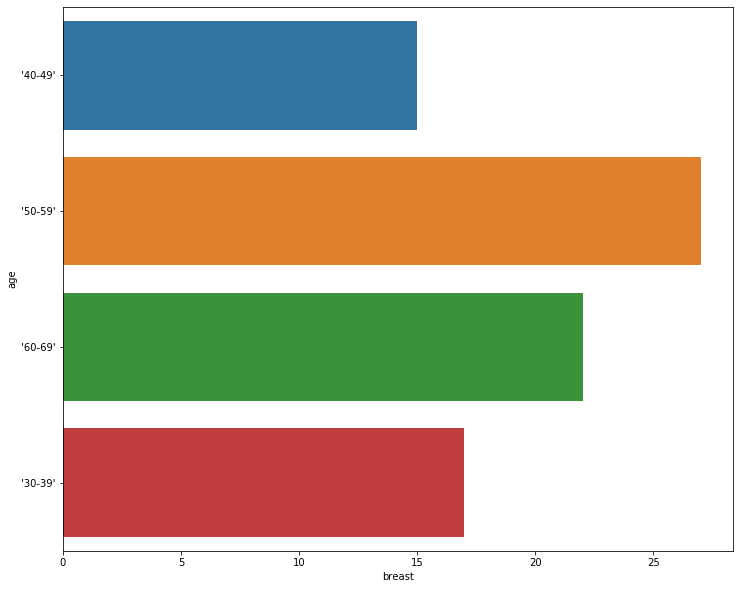

In [34]:
#Distribusi usia yang kambuh
plt.figure(figsize=(12,10))
sns.barplot('breast', totusia_kambuh.index, data=totusia)

In [35]:
#total usia yang tidak kambuh
usia = bc_clean.groupby(['class', 'age']).count()
tot = usia.loc[0,:]
totusia_non = tot.sort_values('breast', ascending=False)

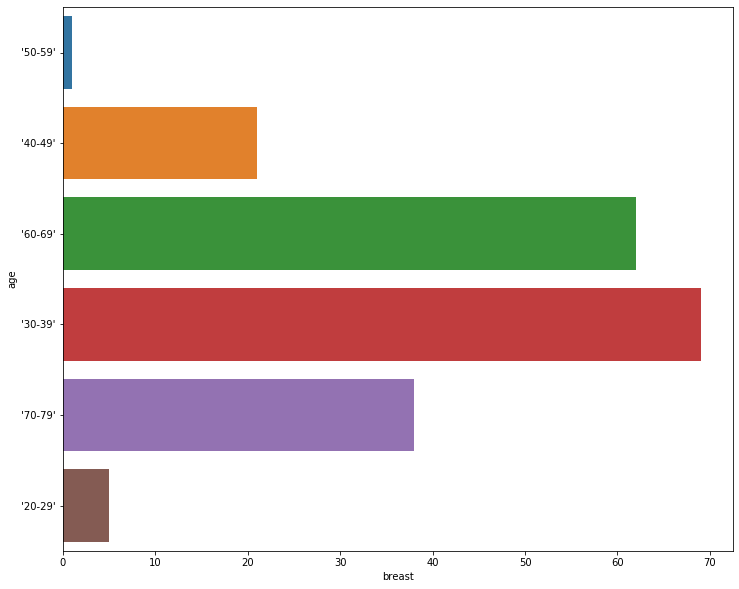

In [36]:
#Distribusi usia tumor yang kambuh
plt.figure(figsize=(12,10))
sns.barplot('breast', totusia_non.index, data=tot)

In [37]:
# total payudara sebelah mana yang biasanya kambuh dan tidak
posisi = bc_dum.groupby(['class'])
totposisi = posisi.sum()
totposisi[["breast_'left'", "breast_'right'"]]

,breast_'left',breast_'right'
class,,
0,100,96
1,45,36


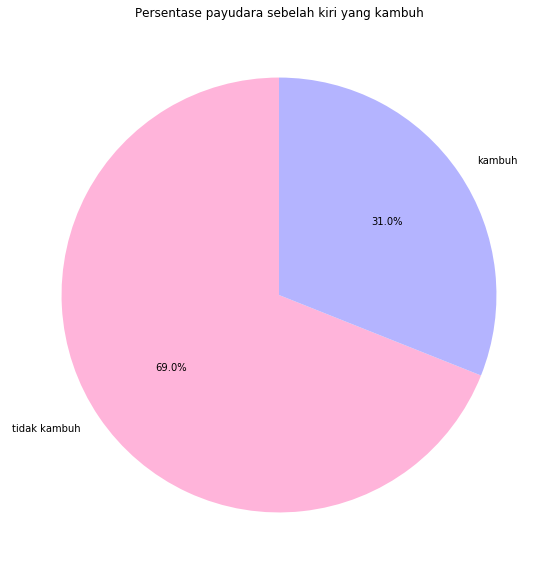

In [38]:
# Persentase yang kambuh untuk payudara sebelah kiri
plt.figure(figsize=(10,10))
plt.title('Persentase payudara sebelah kiri yang kambuh')
plt.pie(totposisi["breast_'left'"], 
        labels=['tidak kambuh', 'kambuh'],
        colors=['#ffb4da', '#b4b4ff'],
        autopct='%1.1f%%', startangle=90)
plt.show()

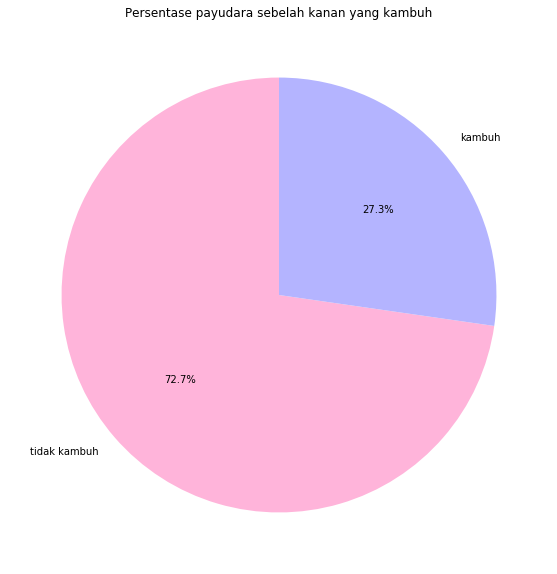

In [39]:
# Persentase yang kambuh untuk payudara sebelah kanan
plt.figure(figsize=(10,10))
plt.title('Persentase payudara sebelah kanan yang kambuh')
plt.pie(totposisi["breast_'right'"], 
        labels=['tidak kambuh', 'kambuh'],
        colors=['#ffb4da', '#b4b4ff'],
        autopct='%1.1f%%', startangle=90)
plt.show()

In [40]:
# checking unique values di tumor_size
bc_clean['tumor_size'].unique()

array(["'15-19'", "'35-39'", "'30-34'", "'25-29'", "'40-44'", "'10-14'",
       "'0-4'", "'20-24'", "'45-49'", "'50-54'", "'5-9'"], dtype=object)

In [41]:
ukuran = bc_clean.groupby(['class', 'tumor_size']).count()
totukuran = ukuran.loc[1,:]
totukuran_kambuh = totukuran.sort_values('breast', ascending=False)

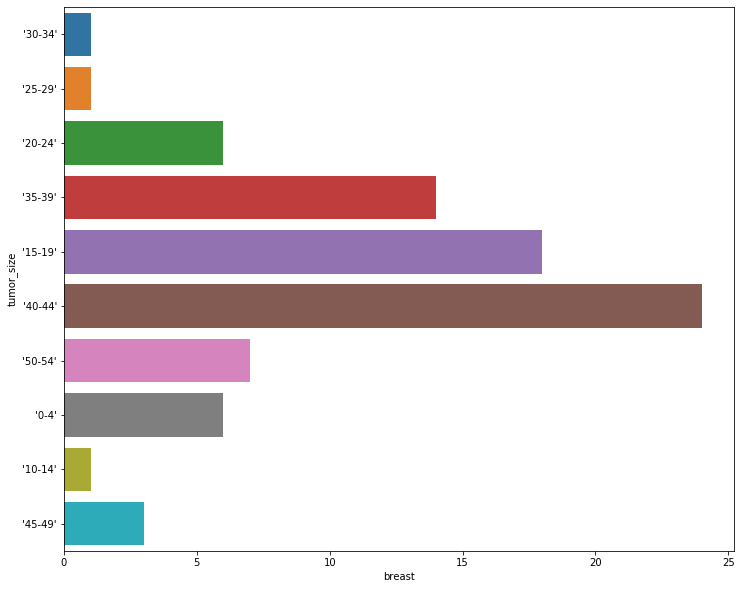

In [42]:
#Distribusi ukuran tumor yang kambuh
plt.figure(figsize=(12,10))
sns.barplot('breast', totukuran_kambuh.index, data=totukuran)

In [43]:
ukuran = bc_clean.groupby(['class', 'tumor_size']).count()
tot = ukuran.loc[0,:]
totukuran_non = tot.sort_values('breast', ascending=False)

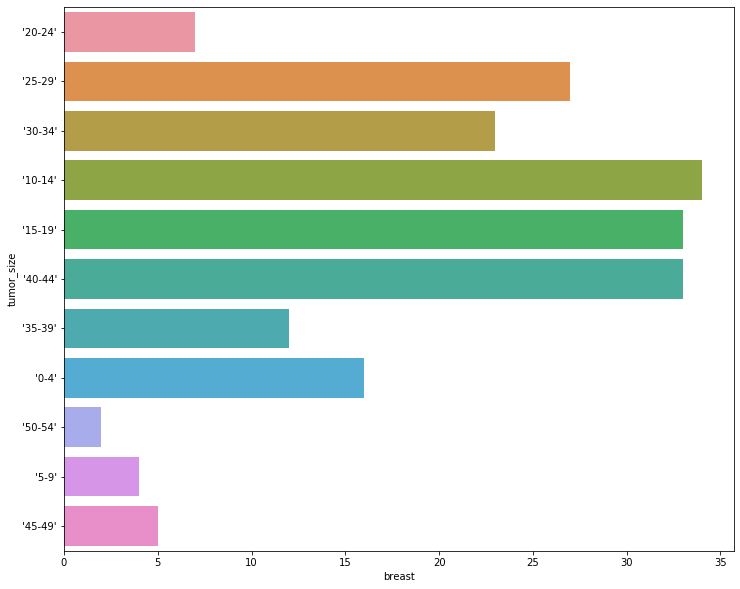

In [44]:
#Distribusi ukuran tumor yang tidak kambuh
plt.figure(figsize=(12,10))
sns.barplot('breast', totukuran_non.index, data=tot)

## 5. Train Data

In [45]:
scaled_bc.isnull().sum()

node_caps                  0
deg_malig                  0
irradiat                   0
age_'20-29'                0
age_'30-39'                0
age_'40-49'                0
age_'50-59'                0
age_'60-69'                0
age_'70-79'                0
menopause_'ge40'           0
menopause_'lt40'           0
menopause_'premeno'        0
tumor_size_'0-4'           0
tumor_size_'10-14'         0
tumor_size_'15-19'         0
tumor_size_'20-24'         0
tumor_size_'25-29'         0
tumor_size_'30-34'         0
tumor_size_'35-39'         0
tumor_size_'40-44'         0
tumor_size_'45-49'         0
tumor_size_'5-9'           0
tumor_size_'50-54'         0
inv_nodes_'0-2'            0
inv_nodes_'12-14'          0
inv_nodes_'15-17'          0
inv_nodes_'24-26'          0
inv_nodes_'3-5'            0
inv_nodes_'6-8'            0
inv_nodes_'9-11'           0
breast_'left'              0
breast_'right'             0
breast_quad_'central'      0
breast_quad_'left_low'     0
breast_quad_'l

In [46]:
scaled_bc.head()

,node_caps,deg_malig,irradiat,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',breast_'left',breast_'right',breast_quad_'central',breast_quad_'left_low',breast_quad_'left_up',breast_quad_'right_low',breast_quad_'right_up',kambuh
0,1.986562,1.293094,-0.537003,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,-0.286411,-0.787327,1.395281,-0.300917,-0.367758,1.0
1,-0.503382,-1.451634,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,2.924333,-0.457829,-0.475041,-0.509010,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,3.491486,-0.787327,-0.716702,-0.300917,-0.367758,0.0
2,-0.503382,-0.079270,-0.537003,-0.060193,-0.386494,-0.688044,1.429670,-0.497743,-0.135582,1.118943,-0.135582,-1.078917,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,-0.509010,3.684962,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,1.270121,-0.716702,-0.300917,-0.367758,1.0
3,1.986562,1.293094,1.862187,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,-0.509010,3.684962,-0.293725,-0.104637,-0.121046,-0.172452,0.570402,-0.104637,-0.148796,-0.060193,-0.374056,-0.255704,-0.161015,-1.048086,1.048086,-0.286411,1.270121,-0.716702,-0.300917,-0.367758,0.0
4,1.986562,-0.079270,-0.537003,-0.060193,-0.386494,1.453396,-0.699462,-0.497743,-0.135582,-0.893701,-0.135582,0.926855,-0.172452,-0.335335,-0.341958,-0.457829,-0.475041,1.964599,-0.271373,-0.293725,-0.104637,-0.121046,-0.172452,-1.753148,-0.104637,-0.148796,-0.060193,2.673398,-0.255704,-0.161015,0.954120,-0.954120,-0.286411,-0.787327,-0.716702,-0.300917,2.719180,1.0


In [47]:
X = scaled_bc.drop('kambuh', axis=1)
y = scaled_bc['kambuh']

In [48]:
y.value_counts()

0.0    187
1.0     81
Name: kambuh, dtype: int64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, test_size=.20, random_state=53)

In [50]:
print(f'X_train = {len(X_train)}')
print(f'X_test = {len(X_test)}')
print('-'*15)
print(f'y_train = {len(y_train)}')
print(f'y_test = {len(y_test)}')

X_train = 214
X_test = 54
---------------
y_train = 214
y_test = 54


## 6. Random Forest

In [51]:
rfc = RandomForestClassifier()

In [52]:
rfc_param = {
    'bootstrap': [True, False],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [int(x) for x in np.arange(10,50,10)],
    'min_samples_split' : [int(x) for x in np.arange(2,10,1)],
    'n_estimators' : [int(x) for x in np.linspace(start=100, stop=1000, num=20)]
}

rfc_random = RandomizedSearchCV(estimator= rfc,
                              param_distributions= rfc_param,
                              n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')
rfc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 147, 194, 242,
                                                         289, 336, 384, 431,
                                                         478, 526, 573, 621,
                                                         668, 715, 763, 810,
                                                         857, 905, 952, 1000]},
                   scoring='roc_auc')

In [53]:
rfc_random.best_params_

{'n_estimators': 431,
 'min_samples_split': 2,
 'max_depth': 20,
 'criterion': 'entropy',
 'bootstrap': False}

In [54]:
rfc_random.best_estimator_.score(X_train,y_train)

0.985981308411215

## 7. Logistic Regression

In [55]:
lr = LogisticRegression()

In [56]:
lr_params = {
    'C': [0.1, 0.5, 0.9, 1, 2, 5],
    'penalty':['l1','l2'],
    'random_state':[24,32,56,65]
}
logreg_random = RandomizedSearchCV(estimator= lr,
                              param_distributions= lr_params,
                              n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')
logreg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=15, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 0.9, 1, 2, 5],
                                        'penalty': ['l1', 'l2'],
                                        'random_state': [24, 32, 56, 65]},
                   scoring='roc_auc')

In [57]:
logreg_random.best_params_

{'random_state': 24, 'penalty': 'l2', 'C': 0.1}

In [58]:
logreg_random.best_estimator_.score(X_test, y_test)

0.6111111111111112

## 8. Decission Tree

In [59]:
dtr = DecisionTreeClassifier()

In [60]:
dtr_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,20,30,40],
    'min_samples_split': [4,5,6,7,8,9],
    'max_features': ['auto', 'sqrt', 'log2']
}
dtr_random = RandomizedSearchCV(estimator= dtr,
                              param_distributions= dtr_params,
                              n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')
dtr_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [4, 5, 6, 7, 8,
                                                              9]},
                   scoring='roc_auc')

In [61]:
dtr_random.best_params_

{'min_samples_split': 6,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'gini'}

In [62]:
dtr_random.best_estimator_.score(X_test, y_test)

0.5555555555555556

In [63]:
best_rfc = rfc_random.best_estimator_
best_lr = logreg_random.best_estimator_
best_dtr = dtr_random.best_estimator_

scores = []
for model in [best_lr, best_dtr, best_rfc]:
    scores.append(model.score(X_train, y_train))

scores_df = pd.DataFrame({'model': ['Logistic Regression', 'Decision Tree', 'Random Forest'], 'scores': scores})
scores_df

,model,scores
0,Logistic Regression,0.724299
1,Decision Tree,0.785047
2,Random Forest,0.985981


## 9. Evaluation Metrics

In [64]:
# Random Forest
predict_rfc = best_rfc.predict(X_test)
proba_rfc = best_rfc.predict_proba(X_test)
print(classification_report(y_test, predict_rfc))
print(confusion_matrix(y_test, predict_rfc))

              precision    recall  f1-score   support

         0.0       0.63      0.85      0.72        34
         1.0       0.38      0.15      0.21        20

    accuracy                           0.59        54
   macro avg       0.50      0.50      0.47        54
weighted avg       0.54      0.59      0.54        54

[[29  5]
 [17  3]]


In [65]:
# Logistic Regression
predict_lr = best_lr.predict(X_test)
proba_lr = best_lr.predict_proba(X_test)
print(classification_report(y_test, predict_lr))
print(confusion_matrix(y_test, predict_lr))

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76        34
         1.0       0.00      0.00      0.00        20

    accuracy                           0.61        54
   macro avg       0.31      0.49      0.38        54
weighted avg       0.39      0.61      0.48        54

[[33  1]
 [20  0]]


In [66]:
predict_dtr = best_dtr.predict(X_test)
proba_dtr = best_dtr.predict_proba(X_test)
print(classification_report(y_test, predict_dtr))
print(confusion_matrix(y_test, predict_dtr))

              precision    recall  f1-score   support

         0.0       0.61      0.82      0.70        34
         1.0       0.25      0.10      0.14        20

    accuracy                           0.56        54
   macro avg       0.43      0.46      0.42        54
weighted avg       0.48      0.56      0.49        54

[[28  6]
 [18  2]]


In [67]:
prob1_lr = proba_lr[:,1]
fpr_lr, tpr_lr, thres_lr = roc_curve(y_test, prob1_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

prob1_dtr = proba_dtr[:,1]
fpr_dtr, tpr_dtr, thres_dtr = roc_curve(y_test, prob1_dtr)
roc_auc_dtr = auc(fpr_dtr, tpr_dtr)

prob1_rfc = proba_rfc[:,1]
fpr_rfc, tpr_rfc, thres_rfc = roc_curve(y_test, prob1_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

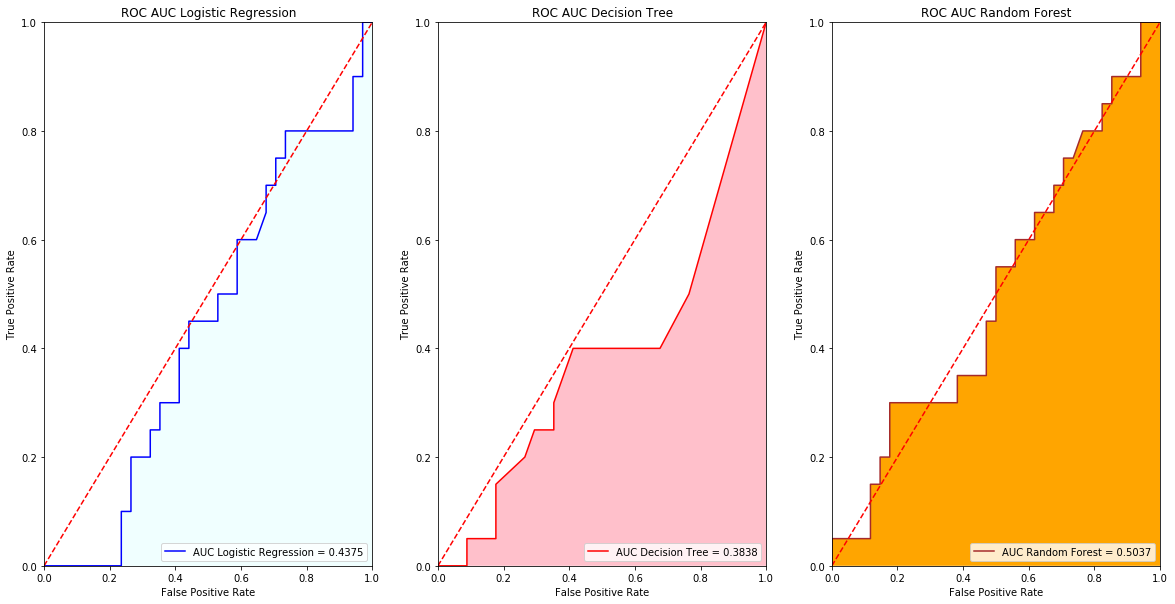

In [68]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('ROC AUC Logistic Regression')
plt.plot(fpr_lr, tpr_lr, 'blue', label='AUC Logistic Regression = {}'.format(round(roc_auc_lr,4)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_lr,tpr_lr, 0, facecolor='azure', alpha=1)
plt.legend(loc = 'lower right')

plt.subplot(132)
plt.title('ROC AUC Decision Tree')
plt.plot(fpr_dtr, tpr_dtr, 'red', label='AUC Decision Tree = {}'.format(round(roc_auc_dtr,4)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_dtr,tpr_dtr, 0, facecolor='pink', alpha=1)
plt.legend(loc = 'lower right')

plt.subplot(133)
plt.title('ROC AUC Random Forest')
plt.plot(fpr_rfc, tpr_rfc, 'brown', label='AUC Random Forest = {}'.format(round(roc_auc_rfc,4)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_rfc,tpr_rfc, 0, facecolor='orange', alpha=1)
plt.legend(loc = 'lower right')

Dari sini bisa dilihat jika model Logistic Regression adalah yg terbaik

In [69]:
from sklearn.metrics import plot_confusion_matrix

In [70]:
lr_rand = logreg_random.best_estimator_

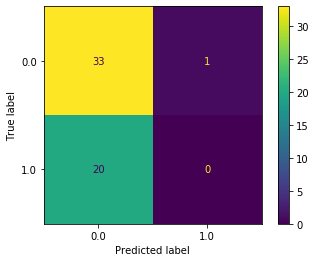

In [71]:
print(plot_confusion_matrix(lr_rand, X_test, y_test))

Pada kasus ini kita fokus kepada skor FP yang sudah lumayan kecil karena bernilai ``1``, yang mana actualnya bukan kambuh tapi diprediksi kambuh.

Jika fokus ke FN yang mana actualnya kambuh tapi diprediksi tidak kambuh itu terlalu risky karena nilai FN sendiri ``20``

## 10. SMOTE

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
y_train.value_counts() # tidak balance antara yang kambuh dan tidak kambuh

0.0    153
1.0     61
Name: kambuh, dtype: int64

In [74]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train,y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [75]:
X_sm

array([[-0.50338223, -0.07927011, -0.53700288, ..., -0.71670161,
        -0.30091723, -0.36775794],
       [-0.50338223,  1.2930937 , -0.53700288, ..., -0.71670161,
        -0.30091723, -0.36775794],
       [ 1.986562  ,  1.2930937 , -0.53700288, ..., -0.71670161,
        -0.30091723,  2.71917991],
       ...,
       [-0.46207946, -0.05650558, -0.49720552, ...,  1.3952808 ,
        -0.30091723, -0.36775794],
       [ 1.986562  ,  0.62350787,  0.69160581, ..., -0.71670161,
        -0.30091723, -0.36775794],
       [-0.50338223, -0.39010472,  1.31878094, ..., -0.71670161,
        -0.30091723, -0.36775794]])

In [76]:
lr_sm = LogisticRegression()
lr_sm.fit(X_sm, y_sm)

LogisticRegression()

In [77]:
pred_lrsm = lr_sm.predict(X_test)
proba_lrsm = lr_sm.predict_proba(X_test)
print(classification_report(y_test, pred_lrsm))
print(confusion_matrix(y_test, pred_lrsm))

              precision    recall  f1-score   support

         0.0       0.55      0.53      0.54        34
         1.0       0.24      0.25      0.24        20

    accuracy                           0.43        54
   macro avg       0.39      0.39      0.39        54
weighted avg       0.43      0.43      0.43        54

[[18 16]
 [15  5]]


In [78]:
# compare dengan Random Forest model yang di awal
print(classification_report(y_test, predict_lr))
print(confusion_matrix(y_test, predict_lr))

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76        34
         1.0       0.00      0.00      0.00        20

    accuracy                           0.61        54
   macro avg       0.31      0.49      0.38        54
weighted avg       0.39      0.61      0.48        54

[[33  1]
 [20  0]]


Bisa dilihat justru data yang sebelum di SMOTE lebih bagus hasilnya dibandingkan yang sudah di SMOTE. Maka, saya fokus ke data yang sebelumnya di SMOTE.

## 11. Using Best Model

In [79]:
proba_lr

array([[0.5916135 , 0.4083865 ],
       [0.82898986, 0.17101014],
       [0.73576179, 0.26423821],
       [0.59360501, 0.40639499],
       [0.67898653, 0.32101347],
       [0.88175932, 0.11824068],
       [0.74772634, 0.25227366],
       [0.69423012, 0.30576988],
       [0.89087291, 0.10912709],
       [0.92063679, 0.07936321],
       [0.75396327, 0.24603673],
       [0.5238984 , 0.4761016 ],
       [0.54337576, 0.45662424],
       [0.69320839, 0.30679161],
       [0.64622053, 0.35377947],
       [0.86570074, 0.13429926],
       [0.88222507, 0.11777493],
       [0.8217966 , 0.1782034 ],
       [0.56076191, 0.43923809],
       [0.7368212 , 0.2631788 ],
       [0.84538812, 0.15461188],
       [0.87343117, 0.12656883],
       [0.59945804, 0.40054196],
       [0.74531214, 0.25468786],
       [0.89504932, 0.10495068],
       [0.62063054, 0.37936946],
       [0.44777273, 0.55222727],
       [0.56073693, 0.43926307],
       [0.76735177, 0.23264823],
       [0.53041524, 0.46958476],
       [0.

In [80]:
from sklearn.metrics import precision_score, recall_score
threshold = [0.5, 0.55, 0.65, 0.7, 0.75]
precision = []
recall = []
for thres in threshold:
    pred = []
    for prob in proba_lr[:,1]:
        if prob>thres:
            pred.append(1)
        else:
            pred.append(0)
    precision.append(round(precision_score(y_test, pred, pos_label=0),5))
    recall.append(round(recall_score(y_test, pred, pos_label=1),5))

In [81]:
print(threshold)
print(precision)
print(recall)

[0.5, 0.55, 0.65, 0.7, 0.75]
[0.62264, 0.62264, 0.62963, 0.62963, 0.62963]
[0.0, 0.0, 0.0, 0.0, 0.0]


In [82]:
print(classification_report(y_test, predict_lr))
print(confusion_matrix(y_test, predict_lr))

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76        34
         1.0       0.00      0.00      0.00        20

    accuracy                           0.61        54
   macro avg       0.31      0.49      0.38        54
weighted avg       0.39      0.61      0.48        54

[[33  1]
 [20  0]]


In [83]:
thres_df = pd.DataFrame({'threshold': threshold, 'precision-': precision, 'recall+': recall})
thres_df

,threshold,precision-,recall+
0,0.50,0.62264,0.0
1,0.55,0.62264,0.0
2,0.65,0.62963,0.0
3,0.70,0.62963,0.0
4,0.75,0.62963,0.0


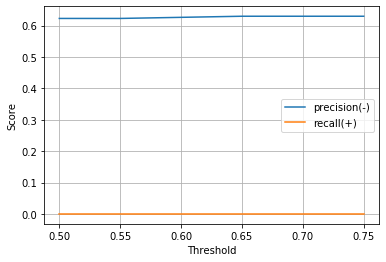

In [84]:
plt.plot(thres_df['threshold'], thres_df['precision-'], label='precision(-)')
plt.plot(thres_df['threshold'], thres_df['recall+'], label='recall(+)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

## 12. PCA

In [85]:
from sklearn.decomposition import PCA

In [86]:
scaled_bc.columns

Index(['node_caps', 'deg_malig', 'irradiat', 'age_'20-29'', 'age_'30-39'',
       'age_'40-49'', 'age_'50-59'', 'age_'60-69'', 'age_'70-79'',
       'menopause_'ge40'', 'menopause_'lt40'', 'menopause_'premeno'',
       'tumor_size_'0-4'', 'tumor_size_'10-14'', 'tumor_size_'15-19'',
       'tumor_size_'20-24'', 'tumor_size_'25-29'', 'tumor_size_'30-34'',
       'tumor_size_'35-39'', 'tumor_size_'40-44'', 'tumor_size_'45-49'',
       'tumor_size_'5-9'', 'tumor_size_'50-54'', 'inv_nodes_'0-2'',
       'inv_nodes_'12-14'', 'inv_nodes_'15-17'', 'inv_nodes_'24-26'',
       'inv_nodes_'3-5'', 'inv_nodes_'6-8'', 'inv_nodes_'9-11'',
       'breast_'left'', 'breast_'right'', 'breast_quad_'central'',
       'breast_quad_'left_low'', 'breast_quad_'left_up'',
       'breast_quad_'right_low'', 'breast_quad_'right_up'', 'kambuh'],
      dtype='object')

In [87]:
pca = PCA(n_components=2)

In [88]:
pca.fit(scaled_bc)

PCA(n_components=2)

In [89]:
x_pca = pca.transform(scaled_bc)

In [90]:
scaled_bc.shape

(268, 38)

In [91]:
x_pca.shape

(268, 2)

In [92]:
x_pca

array([[ 1.55874235e+00, -1.23819867e+00],
       [-2.48444303e+00, -4.46184782e-01],
       [-1.63815491e+00,  1.00382193e+00],
       [ 2.70597440e+00, -4.23184723e-01],
       [ 3.08360004e+00,  8.94925351e-01],
       [ 2.24434356e+00,  2.74047761e-01],
       [-1.52605952e+00,  1.25135070e+00],
       [-8.81768469e-02, -1.94603882e+00],
       [ 3.69036848e-01, -2.90189102e+00],
       [ 2.36188412e+00,  2.15470795e+00],
       [-4.71611135e-01, -5.21385885e-01],
       [-2.18480587e+00,  9.00566114e-02],
       [-1.95766242e+00, -1.52775462e-01],
       [-1.26405756e+00, -1.58592612e-01],
       [ 8.83519081e-01, -1.00066906e+00],
       [ 2.57044413e-02, -9.92932989e-01],
       [ 8.38764846e-01, -6.72477252e-01],
       [-2.18480587e+00,  9.00566114e-02],
       [-3.63786082e-01, -5.12019411e-01],
       [-1.59032274e+00,  9.71397604e-01],
       [-1.91018175e+00,  2.20355069e-01],
       [ 1.16551366e-01, -3.00794985e+00],
       [ 2.64146685e+00,  2.54062143e+00],
       [ 9.

In [93]:
dfpca = pd.DataFrame(x_pca)
dfpca['kambuh'] = bc_dum['class']
dfpca.head()

,0,1,kambuh
0,1.558742,-1.238199,1.0
1,-2.484443,-0.446185,0.0
2,-1.638155,1.003822,1.0
3,2.705974,-0.423185,0.0
4,3.083600,0.894925,1.0


In [94]:
for c in dfpca.columns[0:2]:
    dfpca.rename({int(c): f'PC{int(c)+1}'}, axis=1,inplace=True)

In [95]:
dfpca

,PC1,PC2,kambuh
0,1.558742,-1.238199,1.0
1,-2.484443,-0.446185,0.0
2,-1.638155,1.003822,1.0
3,2.705974,-0.423185,0.0
4,3.083600,0.894925,1.0
...,...,...,...
263,0.241830,4.057750,1.0
264,2.412901,2.197366,NaN
265,3.213819,1.028008,0.0
266,-0.474886,-1.205428,0.0


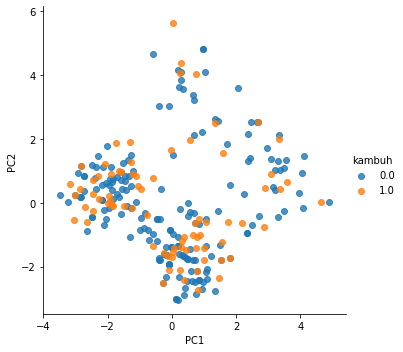

In [96]:
sns.lmplot(x='PC1', y='PC2', hue='kambuh', data=dfpca, fit_reg=False)

Di sini antara yang kambuh dan tidak kambuh susah untuk dipisahkan karena tercampur, jadi tidak bisa menggunakan 2 data saja

In [97]:
pca.components_

array([[ 0.32587365,  0.19894307,  0.23800952,  0.02607298,  0.14057338,
         0.25722769, -0.10756694, -0.26677186, -0.09022688, -0.34739901,
        -0.07781871,  0.36699347, -0.08274705, -0.12495557, -0.10226575,
         0.00963594,  0.05697233,  0.07792294,  0.10401273,  0.02426052,
        -0.01643786, -0.05076559,  0.00305131, -0.35878323,  0.11311743,
         0.10004719,  0.00059906,  0.21933857,  0.10990671,  0.18955688,
        -0.11930601,  0.11930601, -0.10808088, -0.0520448 ,  0.02747151,
         0.03229713,  0.09873665,  0.00423829],
       [ 0.34552125,  0.24598936,  0.17203182, -0.05812016, -0.07705693,
        -0.2664946 ,  0.14987515,  0.21041511, -0.0036519 ,  0.35761398,
        -0.01644777, -0.35200094, -0.0814958 , -0.08626235, -0.01521173,
        -0.00828471, -0.03486958,  0.09852948,  0.00295499,  0.06977982,
         0.06297711, -0.03480803, -0.00510323, -0.37050113,  0.04367474,
         0.10497413,  0.11829091,  0.19190062,  0.26364139,  0.0402086 ,
   

In [98]:
sum(pca.explained_variance_)

6.1938139905940535

Nilai explained variancenya adalah ``6.1938139905940535``

In [99]:
df_comp = pd.DataFrame(pca.components_,columns=scaled_bc.columns, index=['PC1', 'PC2'])

In [100]:
df_comp

,node_caps,deg_malig,irradiat,age_'20-29',age_'30-39',age_'40-49',age_'50-59',age_'60-69',age_'70-79',menopause_'ge40',menopause_'lt40',menopause_'premeno',tumor_size_'0-4',tumor_size_'10-14',tumor_size_'15-19',tumor_size_'20-24',tumor_size_'25-29',tumor_size_'30-34',tumor_size_'35-39',tumor_size_'40-44',tumor_size_'45-49',tumor_size_'5-9',tumor_size_'50-54',inv_nodes_'0-2',inv_nodes_'12-14',inv_nodes_'15-17',inv_nodes_'24-26',inv_nodes_'3-5',inv_nodes_'6-8',inv_nodes_'9-11',breast_'left',breast_'right',breast_quad_'central',breast_quad_'left_low',breast_quad_'left_up',breast_quad_'right_low',breast_quad_'right_up',kambuh
PC1,0.325874,0.198943,0.238010,0.026073,0.140573,0.257228,-0.107567,-0.266772,-0.090227,-0.347399,-0.077819,0.366993,-0.082747,-0.124956,-0.102266,0.009636,0.056972,0.077923,0.104013,0.024261,-0.016438,-0.050766,0.003051,-0.358783,0.113117,0.100047,0.000599,0.219339,0.109907,0.189557,-0.119306,0.119306,-0.108081,-0.052045,0.027472,0.032297,0.098737,0.004238
PC2,0.345521,0.245989,0.172032,-0.058120,-0.077057,-0.266495,0.149875,0.210415,-0.003652,0.357614,-0.016448,-0.352001,-0.081496,-0.086262,-0.015212,-0.008285,-0.034870,0.098529,0.002955,0.069780,0.062977,-0.034808,-0.005103,-0.370501,0.043675,0.104974,0.118291,0.191901,0.263641,0.040209,0.180882,-0.180882,-0.026848,0.110586,-0.052624,-0.039241,-0.033642,-0.002234


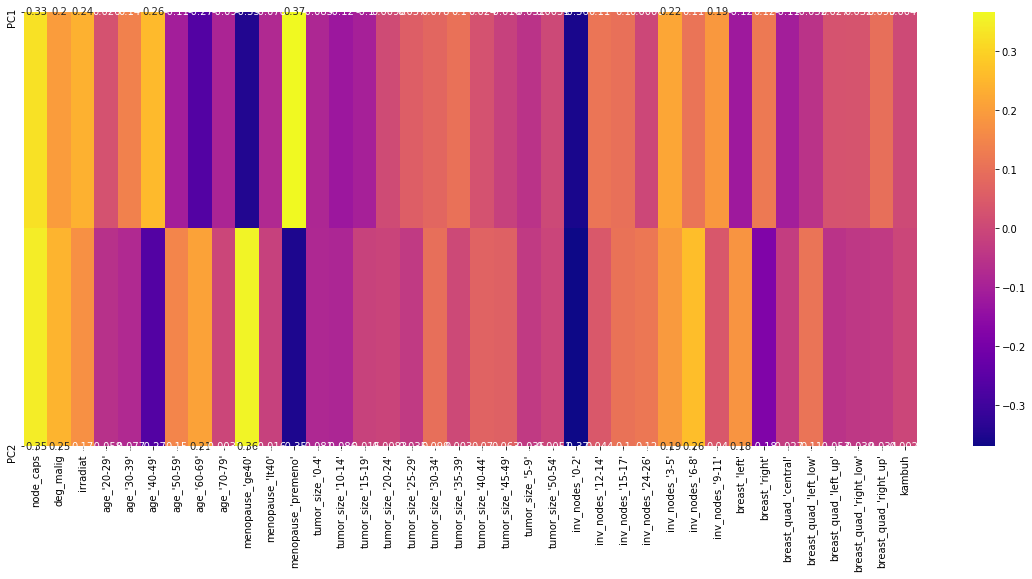

In [101]:
plt.figure(figsize=(20,8))
sns.heatmap(df_comp,cmap='plasma', annot=True)

In [102]:
dfpca.isnull().sum()

PC1       0
PC2       0
kambuh    9
dtype: int64

In [103]:
dfpca_cl = dfpca.drop(dfpca[dfpca.kambuh.isnull() == True].index, axis=0)

In [104]:
X_pca = dfpca_cl.drop('kambuh', axis=1)
y_pca = dfpca_cl['kambuh']

In [105]:
X_trpca, X_tspca, y_trpca, y_tspca = train_test_split(X_pca, y_pca, train_size=.80, test_size=.20, random_state=53)

In [106]:
logreg_pca = LogisticRegression()

In [107]:
lr_paramspca = {
    'C': [0.1, 0.5, 0.9, 1, 2, 5],
    'penalty':['l1','l2'],
    'random_state':[24,32,56,65]
}
logreg_randompca = RandomizedSearchCV(estimator= logreg_pca,
                              param_distributions= lr_paramspca,
                              n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')
logreg_randompca.fit(X_trpca, y_trpca)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=15, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 0.9, 1, 2, 5],
                                        'penalty': ['l1', 'l2'],
                                        'random_state': [24, 32, 56, 65]},
                   scoring='roc_auc')

In [108]:
logreg_randompca.best_params_

{'random_state': 65, 'penalty': 'l2', 'C': 5}

In [109]:
logreg_randompca.best_estimator_.score(X_tspca, y_tspca)

0.7307692307692307

In [110]:
best_lrpca = logreg_randompca.best_estimator_
predict_lrpca = best_lrpca.predict(X_tspca)
proba_lrpca = best_lrpca.predict_proba(X_tspca)
print(classification_report(y_tspca, predict_lrpca))
print(confusion_matrix(y_tspca, predict_lrpca))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84        38
         1.0       0.00      0.00      0.00        14

    accuracy                           0.73        52
   macro avg       0.37      0.50      0.42        52
weighted avg       0.53      0.73      0.62        52

[[38  0]
 [14  0]]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
# compare dengan Random Forest model yang di awal
print(classification_report(y_test, predict_lr))
print(confusion_matrix(y_test, predict_lr))

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76        34
         1.0       0.00      0.00      0.00        20

    accuracy                           0.61        54
   macro avg       0.31      0.49      0.38        54
weighted avg       0.39      0.61      0.48        54

[[33  1]
 [20  0]]


Kesimpulan:
* Usia 50-59 tahun sangat rentan kemungkinan kambuh dari kanker payudara
* Payudara seebelah kiri sangat rentan kemungkinan kambuh daripada yang sebelah kanan
* Jika kambuh, ukuran tumonya 40-42
* Untuk kasus ini logistic regression merupakan model yang bagus
* Untuk FP PCA lebih bagus daripada FP yang belum di PCA hanya saja untuk di PCA, karena dicompress hanya 2 column saja sehingga banyak informasi terbuang dan untuk mencari apakah kemungkinan kambuh atau tidak itu sangat sulit, bisa dilihat dari scatter plotnya.